# 注意力机制
## 注意力提示
- “注意力”：指的是模型分配给它所处理信息中不同部分的权重或重要性分数。
- “提示”：指的是引导模型如何分配这些权重的线索或指令。
- 过程解释：编码器读取输入序列，每个输入词都生成一个隐藏状态，解码器初始化开始生成第一个目标词的时候，它自己的隐藏状态（比如$s_0$）来自编码器的最后一个状态（因为最后一个状态通常包含整个输入序列的信息）或者使用一个特殊的开始标记（提醒解码器开始解码）（一般是解码器自己有一个初始向量或者这个开始标记带着一个学习向量），然后就根据这个初始的向量和编码器的输出向量通过注意力机制计算（用初始向量去乘以每一个编码器的隐藏状态，得到他们各自对应的分数（这个结果就是概率，即相关性），然后将这个分数使用$\mathrm{Softmax}$函数标准化成总和为$1$的概率分布（权重），然后这个权重就是最终的**注意力提示**（模型会注意权重高的）），然后就是上下文向量的更新，各个权重乘以编码器对应位置的各个隐藏状态相加就是更新后的上下文向量（主要是权重最大的对应的隐状态的信息），然后解码器生成第一个词（将初始向量和上下文向量拼接在一起，通过一个前馈神经网络和一个$\mathrm{softmax}$层，然后得到一个覆盖整个目标词汇表的概率分布，概率最高的就是模型预测的第一个词），在之后就是重复上述步骤，直到生成整个序列。
- 注意力机制框架：

![注意力机制框架图](../image/注意力机制框架图.jpg)



## 注意力汇聚：$\mathrm{Nadaraya-Watson}$核回归
### 数据集生成
- 使用非线性函数：$y_i=2\sin(x_i)+x_i^{0.8}+\epsilon$，其中$\epsilon$服从均值为$0$和标准差为$0.5$的正态分布

### 平均汇聚
$$f(x)=\frac{1}{n}\sum^n_{i=1}y_i$$

In [1]:
import collections
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

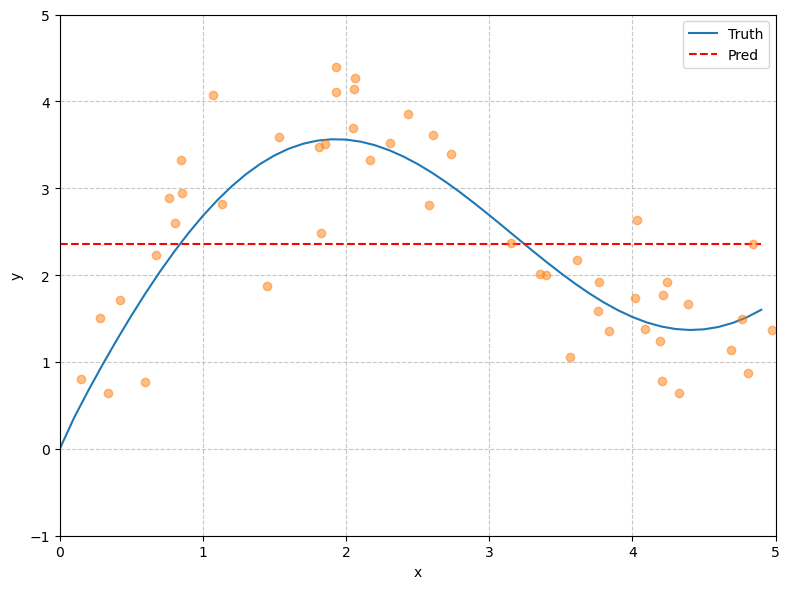

In [2]:
import torch
import matplotlib.pyplot as plt

# 生成数据
n_train = 50
x_train, _ = torch.sort(torch.rand(n_train) * 5)

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))
x_test = torch.arange(0, 5, 0.1)
y_truth = f(x_test)
n_test = len(x_test)

def plot_kernel_reg(y_hat):
    fig, ax = plt.subplots(figsize=(8, 6))
    # 设置白色背景
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    ax.plot(x_test, y_truth, label='Truth')
    # 红色虚线
    ax.plot(x_test, y_hat, 'r--', label='Pred')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim([0.0, 5.0])
    ax.set_ylim([-1, 5])
    ax.legend()
    ax.plot(x_train, y_train, 'o', alpha=0.5)
    ax.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

### 非参数注意力汇聚
- $\mathrm{Nadaraya-Watson}$核回归:
$$f(x)=\sum^n_{i=1}\frac{K(x-x_i)}{\sum_{j=1}^nK(x-x_j)}y_i$$
- 其中$K$是核（函数），由此得出通用的注意力汇聚公式：
$$f(x)=\sum^n_{i=1}\alpha(x,x_i)y_i$$
- 其中$x$是查询，$(x_i,y_i)$是键值对，注意力权重$\alpha(x,x_i)$是查询$x$和键$x_i$之间的关系建模（键越接近查询，那么分配给这个键对应的$y_i$的注意力权重会越大（考虑到一些具体的核函数上））
- **注**：对于任何查询，模型在所有键值对注意力权重都是一个有效的概率分布：它们是非负的，并且总和为1。

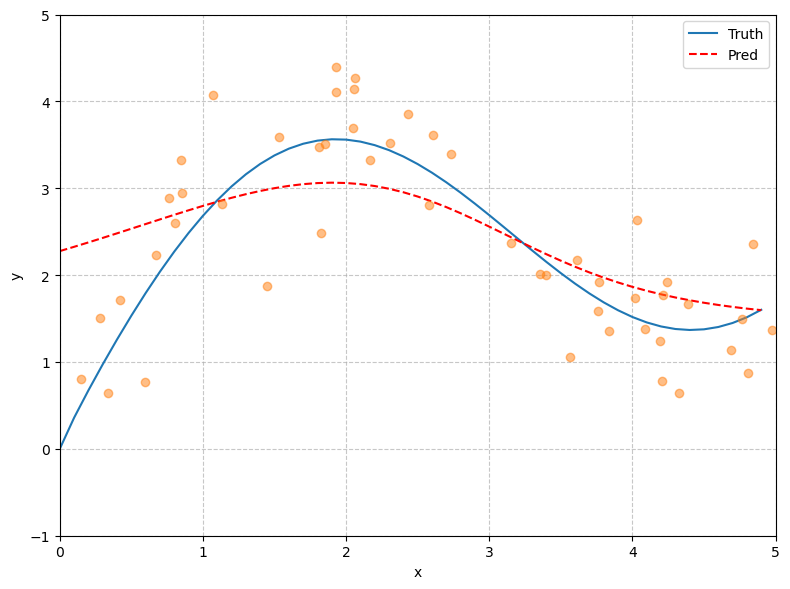

In [3]:
import torch.nn as nn
# X_repeat的形状:(n_test,n_train),
# 每一行都包含着相同的测试输入（例如：同样的查询）
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

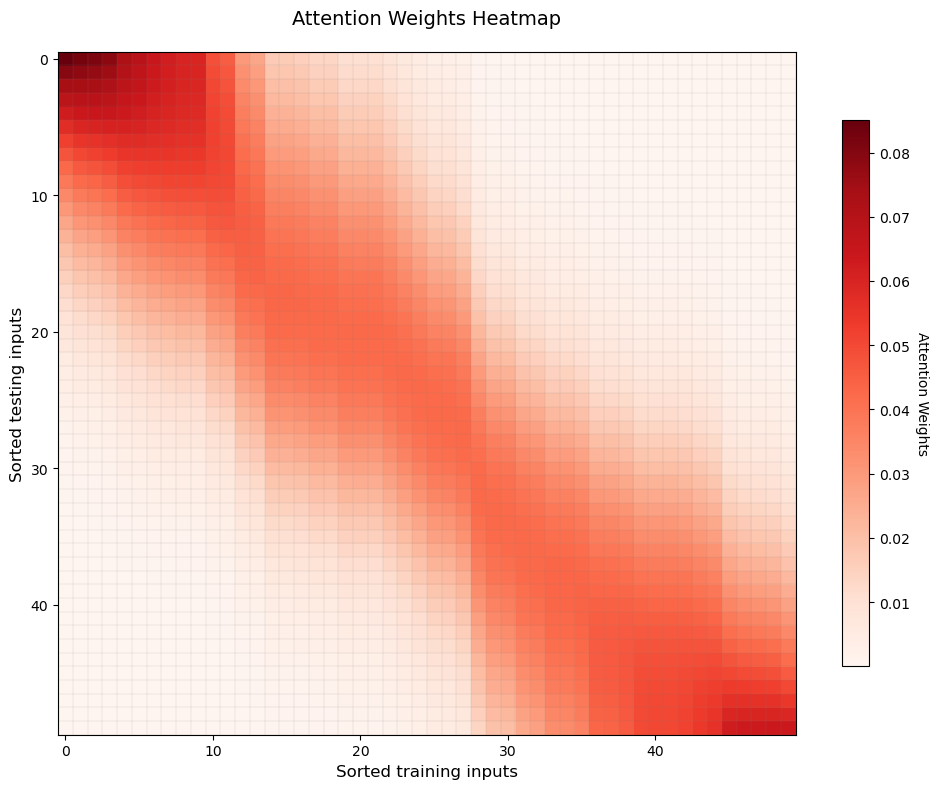

In [5]:
import numpy as np

def show_heatmaps(attention_weights, xlabel='Sorted training inputs', ylabel='Sorted testing inputs',
                 title='Attention Weights Heatmap', figsize=(10, 8), cmap='Reds'):
    """
    显示注意力权重的热力图
    
    参数:
    attention_weights: 注意力权重矩阵 (测试样本数, 训练样本数)
    xlabel: x轴标签
    ylabel: y轴标签
    title: 图标题
    figsize: 图形大小
    cmap: 颜色映射
    """
    # 转换张量为numpy数组
    if hasattr(attention_weights, 'detach'):
        data = attention_weights.detach().numpy()
    elif hasattr(attention_weights, 'numpy'):
        data = attention_weights.numpy()
    else:
        data = np.array(attention_weights)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # 绘制热力图
    im = ax.imshow(data, cmap=cmap, aspect='auto', interpolation='nearest')
    
    # 设置坐标轴标签
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    
    # 添加颜色条
    cbar = fig.colorbar(im, ax=ax, shrink=0.8)
    cbar.ax.set_ylabel('Attention Weights', rotation=-90, va="bottom", fontsize=10)
    
    # 设置标题
    ax.set_title(title, fontsize=14, pad=20)
    
    # 可选：添加网格
    ax.set_xticks(np.arange(-0.5, data.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, data.shape[0], 1), minor=True)
    ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.1)
    ax.tick_params(which="minor", size=0)
    
    plt.tight_layout()
    plt.show()

show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0)[0, 0])

In [6]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

In [7]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

- $\mathrm{Nadaraya‐Watson}$核回归的带参数版模型

In [8]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand(1, requires_grad=True))
    
    def forward(self, queries, keys, values):
        # 一步计算注意力权重，利用广播机制
        diff = queries.unsqueeze(1) - keys.unsqueeze(0)  # (n_queries, n_keys, feature_dim)
        squared_dist = -((diff * self.w) ** 2) / 2
        self.attention_weights = nn.functional.softmax(squared_dist, dim=1)
        
        # 使用einsum进行加权求和
        return torch.einsum('bik,bk->bi', self.attention_weights, values).squeeze()

In [9]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

epoch 1, loss 2647.480225
epoch 2, loss 461.369263
epoch 3, loss 461.369263
epoch 4, loss 461.369263
epoch 5, loss 461.369263


D:\Anaconda\envs\DLL\Lib\site-packages\torch\nn\modules\loss.py:634: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 50])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\27378\AppData\Local\Temp\ipykernel_18124\1908680129.py:15: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:837.)
  current_loss = float(l.sum())


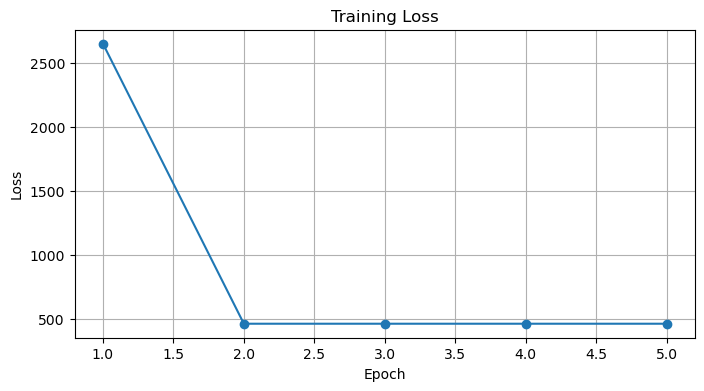

In [10]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)

# 记录训练过程
epochs = 5
losses = []

for epoch in range(epochs):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    
    current_loss = float(l.sum())
    losses.append(current_loss)
    print(f'epoch {epoch + 1}, loss {current_loss:.6f}')

# 绘制损失曲线
plt.figure(figsize=(8, 4))
plt.plot(range(1, epochs + 1), losses, 'o-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

Raw network output: torch.Size([50, 50])
After taking diagonal: torch.Size([50])


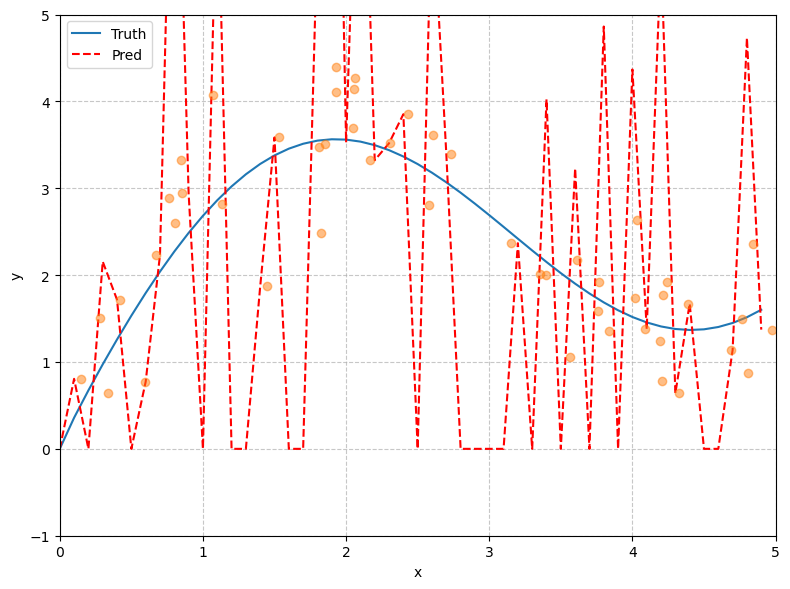

In [11]:
keys = x_train.repeat((n_test, 1))
values = y_train.repeat((n_test, 1))

with torch.no_grad():
    y_hat = net(x_test, keys, values)
    print(f"Raw network output: {y_hat.shape}")  # (50, 50)
    
    # 取对角线元素 - 这通常表示每个查询对应的预测
    y_hat = torch.diag(y_hat)
    print(f"After taking diagonal: {y_hat.shape}")  # (50,)

plot_kernel_reg(y_hat)

## 注意力评分函数
- 其实就是用来计算两个向量之间的相关性（相似度）的

![计算注意力汇聚](../image/注意力汇聚流程.png)

### 掩蔽$\mathrm{softmax}$操作
- 就是用来仅将有意义的词元作为值来获取注意力汇聚的，指定一个有效序列长度（就是词元的个数），然后就可以在$\mathrm{softmax}$的时候过滤掉超出指定长度的位置

In [12]:
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange(maxlen, dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    # X: 3D张量，valid_lens: 1D或2D张量
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                          value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [13]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.5180, 0.4820, 0.0000, 0.0000],
         [0.3863, 0.6137, 0.0000, 0.0000]],

        [[0.2770, 0.4872, 0.2359, 0.0000],
         [0.3116, 0.3855, 0.3029, 0.0000]]])

In [14]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.2894, 0.2592, 0.4514, 0.0000]],

        [[0.4871, 0.5129, 0.0000, 0.0000],
         [0.3687, 0.1496, 0.3316, 0.1501]]])

### 加性注意力（通常针对查询和键是不同长度的矢量）
- 使用单隐藏层的前馈神经网络来计算分数的：
$$score(q, k)=v^T\tanh (W_qq+W_kk)$$
- 就是将$q$（查询）和$k$（键）分别通过线性变换（矩阵乘法$W$）后相加，经过$\tanh$激活函数，最后通过向量$v^T$投影成一个标量。

In [15]:
class AdditiveAttention(nn.Module):
    """加性注意力"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # 在维度扩展后，
        # queries的形状：(batch_size，查询的个数，1，num_hidden)
        # key的形状：(batch_size，1，"键－值"对的个数，num_hiddens)
        # 使用广播方式进行求和
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # self.w_v仅有一个输出，因此从形状中移除最后那个维度。
        # scores的形状：(batch_size，查询的个数，"键-值"对的个数)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # values的形状：(batch_size，"键－值"对的个数，值的维度)
        return torch.bmm(self.dropout(self.attention_weights), values)

# 测试代码
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
# values的小批量，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6])
attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8, dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

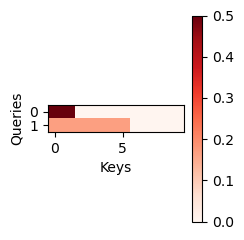

In [16]:
import numpy as np

def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5), cmap='Reds'):
    """显示矩阵热图"""
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize,
                             sharex=True, sharey=True, squeeze=False)
    
    for i in range(num_rows):
        for j in range(num_cols):
            ax = axes[i, j]
            # 将PyTorch张量转换为numpy数组
            if torch.is_tensor(matrices):
                matrix = matrices[i, j].detach().numpy()
            else:
                matrix = matrices[i, j]
            im = ax.imshow(matrix, cmap=cmap)
            
            if titles:
                ax.set_title(titles[i][j])
            
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            
            # 添加颜色条
            fig.colorbar(im, ax=ax)
    
    plt.tight_layout()
    plt.show()

show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
              xlabel='Keys', ylabel='Queries')

### 缩放点积注意力
- 为了解决在算注意力分数的时候，由于向量的维度过高，导致点积结果很大，然后在$\mathrm{Softmax}$的时候梯度变得很小（梯度消失）这个问题，让原本的结果除以一个**缩放因子**（键向量维度的平方根），这样就将这个分数缩放到了一个比较温和的数值范围。
$$\mathrm{softmax}\Big(\frac{\mathbf{QK}^T}{\sqrt{d}}\Big)\mathbf{V}\in\mathbb{R}^{n\times v}$$

In [17]:
import math
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # 设置transpose_b=True为了交换keys的最后两个维度
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [18]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

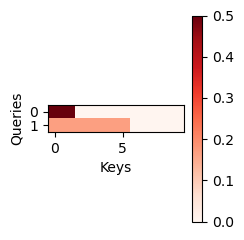

In [19]:
show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
              xlabel='Keys', ylabel='Queries')

## $\mathrm{Bahdanau}$注意力（加性注意力）
- 解码器在生成每个词时，不只依赖一个静态的向量，而是动态地“搜索”输入序列中最相关的部分。
- 该注意力方法允许$\mathrm{Decoder}$在生成的每一步都去查看$\mathrm{Encoder}$的所有隐藏状态，根据相关性赋予不同的权重：
  1. 计算相关性分数：<br>模型会计算$\mathrm{Decoder}$上一步的隐藏状态（$s_{t-1}$）与$\mathrm{Encoder}$每一个隐藏状态（$\mathrm{h_j}$）之间的匹配度（就是看当前的翻译语境和原文的哪个词关系最密切）。
  2. 计算注意力权重：<br>将上述分数通过$\mathrm{Softmax}$函数进行归一化，得到一组概率分布（和为$1$）。分值越高，说明该输入词对当前生成的词越重要。
  3. 计算上下文向量：<br>利用注意力权重，对$\mathrm{Encoder}$的所有隐藏状态进行加权求和，得到当前时刻专属的上下文向量 ($c_t$)。
  4. 生成输出：<br>利用$c_t$和$s_{t-1}$生成当前的隐藏状态$s_t$以及最终的单词$y_t$。
- 评分函数：给定$\mathrm{Decoder}$上一步状态$s_{t-1}$和$\mathrm{Encoder}$的第$j$个状态$h_j$，分数$e_{tj}$，
$$e_tj=v_a^T\tanh(W_as_{t-1}+U_ah_j)$$
- 其中$W_a$和$U_a$是可学习的权重矩阵，$v_a$是一个可学习的向量，$\tanh$是非线性激活函数。
- 归一化操作（$\mathrm{softmax}$）
$$\alpha_{tj}=\frac{exp(e_{tj})}{\sum^{T_x}_{k=1}{exp(e_{tk})}}$$
- 其中，$T_x$是输入序列的长度，$\alpha_{tj}$表示在生成第$t$个词时，应该给予第$j$个输入词多少关注。
- 上下文向量
$$c_t=\sum^{T_x}_{j=1}{\alpha_{tj}h_j}$$

![Bahdanau 注意力](../image/Bahdanau%20注意力.png)

Running on device: cuda
Vocab size: Source=1118, Target=1243
Start Training...
Epoch 15, Loss: 108.811
Epoch 30, Loss: 80.874
Epoch 45, Loss: 67.677
Epoch 60, Loss: 59.580
Epoch 75, Loss: 54.297
Epoch 90, Loss: 50.103
Epoch 105, Loss: 47.141
Epoch 120, Loss: 44.857
Epoch 135, Loss: 42.501
Epoch 150, Loss: 40.835
Epoch 165, Loss: 38.953
Epoch 180, Loss: 37.719
Epoch 195, Loss: 36.651
Epoch 210, Loss: 35.521
Epoch 225, Loss: 34.557
Epoch 240, Loss: 34.030
Epoch 255, Loss: 33.484
Epoch 270, Loss: 32.536
Epoch 285, Loss: 31.792
Epoch 300, Loss: 31.380

Prediction Results:
go . => 开车好！做？何。谁谁, bleu 0.000
i lost . => 我失話了嗎？？？？？, bleu 0.000
he's calm . => 天飞果快。明樂。樂。, bleu 0.000
i am home . => 我在家裡。学校。学校, bleu 0.000

Displaying Heatmap for the last sentence...


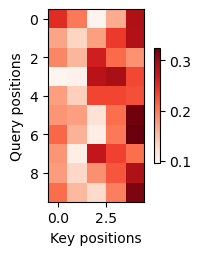

In [28]:
import torch
from torch import nn
from torch.utils import data
import math
import collections
import matplotlib.pyplot as plt # 需要 matplotlib 进行画图

# =============================================================================
# 1. 基础工具函数 (Utilities)
# =============================================================================

def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行 softmax 操作"""
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

def grad_clipping(net, theta):
    """梯度裁剪"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5), cmap='Reds'):
    """显示矩阵热图 (可视化注意力权重)"""
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize,
                             sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6)
    plt.show()

# =============================================================================
# 2. 数据处理与词表 (Data Processing & Vocab)
# =============================================================================

class Vocab:
    """词表类"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None: tokens = []
        if reserved_tokens is None: reserved_tokens = []

        # 统计词频
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)

        # 构建映射
        self.idx_to_token = list(reserved_tokens)
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}

        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.token_to_idx.get('<unk>'))
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self): return 0
    @property
    def token_freqs(self): return self._token_freqs

def count_corpus(tokens):
    """统计词频"""
    if len(tokens) == 0 or isinstance(tokens[0], list):
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

def preprocess_nmt(text):
    """预处理：处理标点符号，确保英文标点与单词分开"""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

def tokenize_nmt(text, num_examples=None):
    """分词：英文按空格，中文按字符"""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) >= 2:
            # Source: English (split by space)
            source.append(parts[0].split(' '))
            # Target: Chinese (character level)
            # 使用 list() 将 "我爱你" 变成 ['我', '爱', '你']
            target.append(list(parts[1]))
    return source, target

def truncate_pad(line, num_steps, padding_token):
    """截断或填充序列"""
    if len(line) > num_steps:
        return line[:num_steps]  # 截断
    return line + [padding_token] * (num_steps - len(line))  # 填充

def build_array_nmt(lines, vocab, num_steps):
    """将文本序列转换为索引张量"""
    lines = [vocab[l] for l in lines]
    lines = [truncate_pad(l, num_steps, vocab['<pad>']) for l in lines]
    array = torch.tensor(lines)
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len

def load_data_nmt(batch_size, num_steps, num_examples=5000):
    """加载 cmn.txt 数据集"""
    # 读取文件
    try:
        with open('../data/cmn.txt', 'r', encoding='utf-8') as f:
            raw_text = f.read()
    except FileNotFoundError:
        print("错误：找不到文件 ../data/cmn.txt，请检查路径。")
        exit()

    text = preprocess_nmt(raw_text)
    source, target = tokenize_nmt(text, num_examples)

    # 构建词表
    src_vocab = Vocab(source, min_freq=2, reserved_tokens=['<unk>', '<pad>', '<bos>', '<eos>'])
    tgt_vocab = Vocab(target, min_freq=2, reserved_tokens=['<unk>', '<pad>', '<bos>', '<eos>'])

    # 构建张量
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)

    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    dataset = data.TensorDataset(*data_arrays)
    data_iter = data.DataLoader(dataset, batch_size, shuffle=True)

    return data_iter, src_vocab, tgt_vocab

# =============================================================================
# 3. 模型架构组件 (Model Architecture)
# =============================================================================
# (这部分代码与你提供的完全一致，未做修改)

class AdditiveAttention(nn.Module):
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

class Seq2SeqEncoder(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super(Seq2SeqEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout=dropout)

    def forward(self, X, *args):
        X = self.embedding(X).permute(1, 0, 2)
        output, state = self.rnn(X)
        return output.permute(1, 0, 2), state

class Seq2SeqAttentionDecoder(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super(Seq2SeqAttentionDecoder, self).__init__()
        self.attention = AdditiveAttention(num_hiddens, num_hiddens, num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        outputs, hidden_state = enc_outputs
        return (outputs, hidden_state, enc_valid_lens)

    def forward(self, X, state):
        enc_outputs, hidden_state, enc_valid_lens = state
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens)
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction = 'none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

# =============================================================================
# 4. 训练与预测 (Training & Prediction)
# =============================================================================

def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    def xavier_init_weights(m):
        if type(m) == nn.Linear: nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param: nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()

    for epoch in range(num_epochs):
        metric = [0.0, 0.0]
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0], device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()
            grad_clipping(net, 1)
            optimizer.step()
            metric[0] += l.sum().item()
            metric[1] += 1

        if (epoch + 1) % 15 == 0:
            print(f'Epoch {epoch + 1}, Loss: {metric[0] / metric[1]:.3f}')

def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    net.eval()
    # 预处理预测输入
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tensor = torch.tensor([src_tokens], dtype=torch.long, device=device)
    # Pad
    if len(src_tokens) < num_steps:
        pad_len = num_steps - len(src_tokens)
        src_tensor = torch.cat([src_tensor, torch.tensor([src_vocab['<pad>']] * pad_len, device=device).unsqueeze(0)], dim=1)

    enc_outputs = net.encoder(src_tensor, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)

    dec_input = torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device).unsqueeze(0)
    output_seq, attention_weight_seq = [], []

    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_input, dec_state)
        dec_input = Y.argmax(dim=2)
        pred = dec_input.squeeze(0).item()

        if save_attention_weights:
            # 这里的 [0] 是修正那个 list of tensors 的关键
            attention_weight_seq.append(net.decoder.attention_weights[0])

        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)

    return ''.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

def bleu(pred_seq, label_seq, k):
    """计算BLEU (针对字符级中文简单的实现)"""
    pred_tokens = list(pred_seq)
    label_tokens = list(label_seq)
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[''.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[''.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[''.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

# =============================================================================
# 5. 主程序 (Main Execution)
# =============================================================================

if __name__ == "__main__":
    # 配置
    embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
    batch_size, num_steps = 64, 10
    lr, num_epochs = 0.005, 300

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Running on device: {device}")

    # 1. 加载真实数据
    # num_examples 控制使用多少条数据训练，设小一点(如600)方便快速演示，
    # 设为 None 则使用全部数据 (可能需要调大网络和Epoch)
    train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps, num_examples=5000)
    print(f"Vocab size: Source={len(src_vocab)}, Target={len(tgt_vocab)}")

    # 2. 模型
    encoder = Seq2SeqEncoder(
        len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
    decoder = Seq2SeqAttentionDecoder(
        len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
    net = EncoderDecoder(encoder, decoder)

    # 3. 训练
    print("Start Training...")
    train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

    # 4. 预测
    print("\nPrediction Results:")
    # 根据 cmn.txt 的内容选择一些简单的句子测试
    engs = ['go .', 'i lost .', 'he\'s calm .', 'i am home .']
    chns = ['走。', '我迷失了。', '他很冷静。', '我到家了。'] # 对应的中文供参考

    dec_attention_weight_seq = None

    for eng, chn in zip(engs, chns):
        translation, dec_attention_weight_seq = predict_seq2seq(
            net, eng, src_vocab, tgt_vocab, num_steps, device, True)
        print(f'{eng} => {translation}, bleu {bleu(translation, chn, k=2):.3f}')

    # 5. 可视化注意力
    if dec_attention_weight_seq:
        # 拼接: (1, pred_steps, 10)
        attention_weights = torch.cat(dec_attention_weight_seq, dim=1)

        # Reshape为 (1, 1, pred_steps, num_steps) 以适配 visualize
        # 注意：这里我们让最后一维也是动态的，不强制 resize 成 10，以防出错
        final_shape_weights = attention_weights.reshape((1, 1, -1, num_steps))

        # 截取对应输入长度的 Attention
        # (因为输入被 pad 到了 num_steps，但我们只关心实际单词的 attention)
        src_len = len(engs[-1].split()) + 1 # +1 for eos

        print("\nDisplaying Heatmap for the last sentence...")
        show_heatmaps(
            final_shape_weights[:, :, :, :src_len].cpu(),
            xlabel='Key positions',
            ylabel='Query positions'
        )